In [ ]:
# Listing 8.1 Reweighting a probability distirbution to a different temperature

import numpy as np

# low temperature will make the distribution more deterministic
# high temperature will make the distribution more uniform (random)

def reweight_distribution(original_distribution, temperature=0.5):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    # make sure sum of prob distribution is 1
    return distribution / np.sum(distribution)


In [ ]:
# Listing 8.2 Downloading and parsing the initial text file
import keras
import numpy as np

path = keras.utils.get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('Corpus length: ',len(text))


In [ ]:
# Listing 8.3 Vectorising sequences of characters

# extract sequences of 60 characters
maxlen = 60
# sample new sequence every three characters
step = 3
# something to hold the extracted sequences
sentences = []
# hold the followup characters
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i:i + maxlen])
    next_chars.append(text[i + maxlen])

print('Number of sequences: ', len(sentences))

# get a list of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters: ', len(chars))

# dictionary that maps unique characters to their index in the list "chars"
char_indices = dict((char, chars.index(char)) for char in chars)

print('Vectorisation...')
# one-hot encodes the charcters into binary arrays
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    

In [ ]:
# Listing 8.4 Single Layer LSTM model for next-character prediction
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape = (maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model.summary()


In [ ]:
# Listing 8.6 Function to sample next character given the model's predictions
# How to generate new text:
# 1. Draw from the model a probability distribution for the next character given the generated text available so far
# 2. Reweight the distribution to a certain temperature
# 3. Sample the next character at random according to the re-weighted distribution
# 4. Add the new character to the end of the available text

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    # probabilities - 1 experiment with prediction probs for each charact and return once
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
# Listing 8.7 Text-generation loop

import random
import sys

# trains the model for 60epochs
for epoch in range(1,60):
    print('epoch: ',epoch)
    # fits the model for one iteration on thye data
    model.fit(x,y, batch_size=128, epochs=1)
    # select text seed at random
    start_index = random.randint(0, len(text) - maxlen -1)
    generated_text = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + generated_text + '"')

    # tries a range of different sampling temperatures
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('----- temperature: ', temperature)
        sys.stdout.write(generated_text)

        # generates 400 characters starting from the seed text
        for i in range(400):
            # one hot encode the characters generated so far
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1

            # samples the next character
            preds = model.predict(sampled, verbose=0)[0] #<-- what does the [0] do??
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)

In [ ]:
# 8.2 DeepDream

# Start with pretrained convnet (ImageNet)
# Different convnet architectures will result in different learned features

# Maximise the activation of entire layers rather than that of a specific filter 
# thus mixing together visualisations of large numbers of features at once

# Start from existing image, effects latch on to preexisting visual patterns

from keras.applications import inception_v3
from keras.applications import VGG16
from keras import backend as K

# We don't train model so this command disables all training-specific operations
K.set_learning_phase(0)

# Build the inception v3 network without its convolutional base (include_top=False).
# Model will be loaded with pretrained weights
#model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

# Build the VGG16 network without convolutional base
model = VGG16(weights='imagenet', include_top=False)


In [ ]:
# Listing 8.9 Setting up the DeepDream configuration
# Compute loss - maximise this during the gradient ascent
# Simulaneously maximise the activation in a number of layers - L2 norm of activations of a set of high level layers
# Lower layers result in geometric patterns
# Higher layers result in objects that can be recognised in the imagenet
# This configuration is arbitrary so worth experimenting

model.summary()

# Dictionary mapping layer names to coefficients specifying how much layer activation contributes to loss
# 4 layers somewhat arbitrary can experiment with different numbers

#layer_contributions = {'mixed2': 0.2, 'mixed3': 3., 'mixed4': 2., 'mixed4': 2., 'mixed5': 1.5,}
layer_contributions = {'block2_conv1': 0.2, 'block3_conv1': 2.0, 'block4_conv1': 1.5, 'block5_conv1': 0.5,}


In [ ]:
# Listing 8.10 Defining the loss to be maximised

# Create a dictionary that maps layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# define loss by adding layer contributions to this variable
loss = K.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    # retrieve the layer output
    activation = layer_dict[layer_name].output
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # Add L2 norm of features of the layer to the loss (avoid border artifacts by only involving nonborder pixels)
    loss += coeff * K.sum(K.square(activation[:, 2:-2, 2:-2, :])) / scaling

In [ ]:
# Listing 8.11 Gradient-ascent process

# tensor to hold the generated image - the dream
dream = model.input

# compute gradients of the dream with regard to the loss
grads = K.gradients(loss, dream)[0]

# Normalise the gradients (important !?)
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up Keras function to retieve the value of the loss and gradients given an input image
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# function to run gradient ascent for a number of iterations
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x


In [ ]:
# Listing 8.13 Auxiliary FUnctions
import numpy as np
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1, float(size[0]) / img.shape[1], float(size[1]) /  img.shape[2], 1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)

def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

# convert a tensor into a valid image
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # undoes preprocessing that was performed by preproces above
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    

In [ ]:
# Listing 8.12 Running gradient ascent over different successive scales - detail reinjection

# gradient ascent step size
step = 0.01
# number of scales at which to run gradient ascent
num_octave = 3 #3
# size ratio between scales
octave_scale = 1.4 #1.4
# number of ascent steps to run at each scale
iterations =20
# interrupt grad ascent for loss larger than 10
max_loss = 1000.

base_image_path = '/home/david/Pictures/new_plymouth_lilli.jpg'
#base_image_path = '/home/david/Pictures/sashiko_1.jpg'

# load base image into a numpy array
img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]
print('img.shape: ',original_shape)
new_shape = tuple([int(dim / (8)) for dim in original_shape])
img = resize_img(img, new_shape)
#img = resize_img(img, original_shape)

# prepare a list of shape tuples defining different scales
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# reverses the list of shapes so they are in increasing order
successive_shapes = successive_shapes[::-1]

# resize the numpy array of the image to the smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    # scales up the deep dream image
    img = resize_img(img, shape)
    img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)
    # scales up the smaller version of the original image
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    # computes the high-quality version of the original image at this size
    same_size_original = resize_img(original_img, shape)
    # the difference between the two is the detail that was lost when scaling up
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    # reinject lost detail into the dream
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='/home/david/Pictures/final_dream.png')

img_out = deprocess_image(img)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14, 14))
plt.imshow(img_out)

In [ ]:
import imageio
pil_img = deprocess_image(np.copy(img))
imageio.imwrite('/home/david/Pictures/final_dream.png', img[0,:,:])

## 8.3 Neural Style Transfer

Content loss - L2 norm between activations in the upper layers of pretrained convnet computed over taget image and activations of the same layer computed over the generated image.

Style loss - Capture appearence over many spatial scales. Use Gram matrix of a layer's activations: inner product of the feature maps of a given layer.

Approach:

1. etup network that computes VGG19 layer activations for a the style-reference, target and generated image.
2. Use layer activations over these three images to calculate the loss function with which we will achieve style transfer.
3. Setup a gradient descent process to minimise the loss function.

In [73]:
# Listing 8.14 Defining initial variables

from keras.preprocessing.image import load_img, img_to_array

target_image_path = '/home/david/Pictures/new_plymouth_lilli.jpg'
#target_image_path = '/home/david/Pictures/sashiko_5.jpg'
style_reference_image_path = '/home/david/Pictures/sashiko_4.jpg'
#style_reference_image_path = '/home/david/Pictures/new_plymouth_lilli.jpg'

# dimensions of the generated image
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)


In [74]:
# Listing 8.15 Auxiliary Functions

import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# convert a tensor into a valid image
def deprocess_image(x):
    # zero-centering by removing the mean pixel value from imagenet
    # this reverses a transformation done by vgg19.preprocess_input
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.799
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1] # convert BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [75]:
# Listing 8.16 Loading the pretrained VGG19 network and applying it to the three images

from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))

# combines three images into a single batch
input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis=0)

# build VGG19 network with pretrained imagenet weights
model = vgg19.VGG19(input_tensor = input_tensor, weights = 'imagenet', include_top = False)
print('Model loaded.')

Model loaded.


In [76]:
# Listing 8.17 Content loss

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [77]:
# Listing 8.18 Style loss - use ausxiliary function to compute the Gram matrix

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size **2))

In [78]:
# Listing 8.19 Total Variation loss - minimise in combination image to encourage spatial continuity

def total_variation_loss(x):
    a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [79]:
# Listing 8.20 Defining the final loss to be minimised

# weighted average of content, style and total variation loss
# - use upper layer of content loss
# - use low and high layers for style loss
# - add TV at end

# dictionary tat maps layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# weights for loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# adds content loss
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features, combination_features)

# adds style loss
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl

# add total variation loss
loss += total_variation_weight * total_variation_loss(combination_image)

In [80]:
# Gradient descent uses a python class named Evaluator to compute loss and gradients at once 
# thus implementing L-BFS
# returns loss value when called first time and caches the gradients for the next call

# Listing 8.21 Setting up the gradient descent process

# get gradients of the generated image with regard to loss
grads = K.gradients(loss, combination_image)[0]

# fetch values of current loss and current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

# class wrapts fetch_loss_and_grads in a way that lets you retieve the 
# losses and grads via teo separae methods calls as required by SciPy optimiser

class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grad_values = None
    
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()
    

In [81]:
# Listing 8.22 Style transfer loop wth gradient descent process

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'my_result'
iterations = 20

# initial state - the target image
x = preprocess_image(target_image_path)
# flatten iamge for optimiser
x = x.flatten()
for i in range(iterations):
    print('Start of iteration ', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
    print('Current loss value: ', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    print('Image saved as ', fname)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration  0
Current loss value:  13222277000.0
Image saved as  my_result_at_iteration_0.png
Iteration 0 completed in 5s
Start of iteration  1


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value:  6678962000.0
Image saved as  my_result_at_iteration_1.png
Iteration 1 completed in 5s
Start of iteration  2
Current loss value:  4345559600.0
Image saved as  my_result_at_iteration_2.png
Iteration 2 completed in 5s
Start of iteration  3
Current loss value:  3086575400.0
Image saved as  my_result_at_iteration_3.png
Iteration 3 completed in 5s
Start of iteration  4
Current loss value:  2348542200.0
Image saved as  my_result_at_iteration_4.png
Iteration 4 completed in 5s
Start of iteration  5
Current loss value:  1913433900.0
Image saved as  my_result_at_iteration_5.png
Iteration 5 completed in 5s
Start of iteration  6
Current loss value:  1604623200.0
Image saved as  my_result_at_iteration_6.png
Iteration 6 completed in 5s
Start of iteration  7
Current loss value:  1391569500.0
Image saved as  my_result_at_iteration_7.png
Iteration 7 completed in 5s
Start of iteration  8
Current loss value:  1241293400.0
Image saved as  my_result_at_iteration_8.png
Iteration 8 comple

## 8.4.3 Variational Autoencoders

Here we will learn to encode and decode images (MNIST)
Parameters of the VAE are trained via two loss functions:
1. Reconstruction loss (forces decoded samples to match initial input)
2. Regularisation loss (promotes well-formd latent spaces, reduces overfitting)

In [1]:
# Listing 8.23 VAE Encoder Network
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2 # dimensionatlity of latent space is a 2D plane

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Encode image into these parameters - just sets up layers that take the output of the final dense layer
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(None, 14, 14, 64)


In [5]:
# Listing 8.24 Latent-space-sampling function

# draws a layent point using small random epsilon

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var)*epsilon

# wrap sampling function into a Lambda layer (custom layer)
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [6]:
# Listin 8.25 VAE decoder network, mapping latent space points to images

# this is the input in which to feed he latent-space samples z
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsamples the input
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

# note shape_before_flattening looks like an image
x = layers.Reshape(shape_before_flattening[1:])(x)

# use conv2d transpose and con2d layer to decode z to a feature map that is size of original
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)

x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# instantiates the decoder model decoder_input -> decoded image
decoder = Model(decoder_input, x)

# applies model to z to recover decoded z
z_decoded = decoder(z)

In [10]:
# Listing 8.26 Custom lyer used to compute the VAE loss

# dual loss of a VAE doesn't fit the traditiona expectation of a saple-wise funtion ofthe form loss(input, target)

class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    # implement custom layers by writing a call method
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        # add loss to the symbolic graph
        self.add_loss(loss, inputs=inputs)
        # return value required but not used
        return x

# Call the customised layer on the input and the decoded output to obtain final model output
y = CustomVariationalLayer()([input_img, z_decoded])

In [11]:
# Listing 8.27 Training the VAE

from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss = None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
print('x_train.shape: ',x_train.shape)
x_train = x_train.reshape(x_train.shape + (1,)) # (1,) adds extra dimension for keras fit function
print('x_train.shape: ', x_train.shape)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Output "custom_variational_layer_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_3" during training.
  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

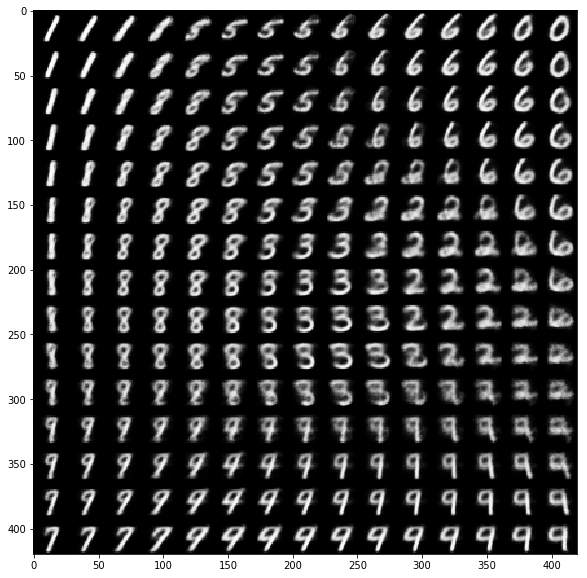

In [18]:
# Listing 8.28 Sampling a grid of points from the 2D latent space and decoding them to images

import matplotlib.pyplot as plt
from scipy.stats import norm

# display a grid of 15x15 digits (255 total)

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# transform linearly spaced cordinates using scipy ppf function to produce values of the latent variable z
# (becuase the prior of the latent space is gaussian)
# ppf is the inverse of the cdf (stands for point percent function - or quantiles)
grid_x = norm.ppf(np.linspace(0.05,0.95, n))
grid_y = norm.ppf(np.linspace(0.05,0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Create the z_sample
        z_sample = np.array([xi, yi])
        # repeat z multiple times to form a complete batch
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i*digit_size: (i+1)*digit_size, j*digit_size:(j+1)*digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## Generative Adversarial Networks

We use Conv2DTranspose for image upsampling in the generator

Schematically:
1. A generator network maps vectors of shape (latent_dim,) to images of shape (32, 32, 3)
2. A discriminator networkmaps images of shape (32, 32, 3) to a binary score estimating the probability that the image is real
3. A gan chains the generator and discriminator together: gan(x) = discriminator(generator(x)). This creates a mapping of latent space vectors to discriminator assessment of realism of the latent vectors as decoded by the generator.
4. Train discriminator using examples of real and fake images along with labels.
5. Train generator using gradients of the generator's weights with regard to the loss of the gan model i.e. move weights in the direction that makes the discriminator more likely to classifiy as "real" the images decoded by the generator.

Bare in mind the bag of tricks that are used to help train these models:
1. Use tanh as the last activation
2. Sample points from the latent sapce using a normal distribution, not a uniform distribution
3. Stochasticity is good for robustness. GAN training results in a dynamic equilibrium so they get stuck. Examples of randomness are dropout in the discriminator and added label noise.
4. Sparse gradients hinder GAN training. Max pooling and ReLU induce sparsity. Use strided convolutions for downsampling and LeakyReLU for activation.
5. Checkerboard artifacts caused by mismatching strides and kernel sizes. Make kernel size divisible by the stride size.

In [31]:
# Listing 8.29 GAN generator network

import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# transform the input into a 16x16 128-channel feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# this layer upsamples to 32 x 32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# produces a 32x32 1-channel feature map (shape of the image)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

In [32]:
# Listing 8.30 The GAN discriminator network

discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

# this is the classification layer
x = layers.Dense(1, activation='sigmoid')(x)

# discriminator instantiation
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# gradient clipping in the optimiser
# learning rate decay stabilises training - related to use in RL
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 6, 6, 128)         0         
__________

In [33]:
# Listing 8.31 Adversarial Network

# It is important to set the discriminator to freeze during training of the gan. If not then the discriminator
# weights would update to predict "real"

discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

Training of the gan (per epoch):

1. Draw random points in the latent space
2. Generate images with the generator
3. Mix generated images with real ones
4. Train discriminator used mixed images with corresponding targes i.e. "real" or "fake"
5. Draw new random points in the latent space
6. Train gn using these random vectors, with targets that all say "these are real iamges" to update weights of the generator (discriminator frozen in the gan at this point)


In [40]:
# Listing 8.32 Implementing GAN training

import os
from keras.preprocessing import image

(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# select the frog images
x_train = x_train[y_train.flatten() == 6]
print("x_train.shape: ",x_train.shape)

# normalise the data
x_train = x_train.reshape((x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.
print("x_train.shape: ",x_train.shape)

iterations = 10000
batch_size = 20
save_dir = os.path.join(os.getcwd(),'./gan_dir/')
print(os.getcwd())

start = 0

for step in range(iterations):
    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # decode images to fake
    generated_images = generator.predict(random_latent_vectors)
    #print("generated_images.shape: ",generated_images.shape)
    
    stop = start + batch_size
    real_images = x_train[start: stop]
    #print("real_imges.shape: ",real_images.shape)
    
    combined_images = np.concatenate([generated_images, real_images])
    
    # assemble labels, discrminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    # add random noise to labels - this adds stochasticity which magically makes things better
    labels += 0.05 * np.random.random(labels.shape)
    
    # train the discriminatpr
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # assembles labels that say these are real (when they are not)
    misleading_targets = np.zeros((batch_size, 1))
    
    # trains the generator
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    
    if step % 100 == 0:
        gan.save_weights('gan.h5')
    
        print('discriminator loss: ', d_loss)
        print('adversarial loss: ', a_loss)
        
        # save a generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' +str(step) + '.png'))
        
        # saves one real iamge for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' +str(step) + '.png'))


x_train.shape:  (5000, 32, 32, 3)
x_train.shape:  (5000, 32, 32, 3)
/home/david/dev
discriminator loss:  0.50092405
adversarial loss:  1.437214


/usr/local/lib/python3.5/dist-packages/Keras-2.1.4-py3.5.egg/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss:  0.66101414
adversarial loss:  0.7261237
discriminator loss:  0.74065244
adversarial loss:  0.65775645
discriminator loss:  0.70804745
adversarial loss:  0.8963131
discriminator loss:  0.6898038
adversarial loss:  0.7610234
discriminator loss:  0.70669276
adversarial loss:  0.7535685
discriminator loss:  0.66862357
adversarial loss:  0.7447093
discriminator loss:  0.6878894
adversarial loss:  0.8450198
discriminator loss:  0.6941849
adversarial loss:  0.742218
discriminator loss:  0.7029648
adversarial loss:  0.73533237
discriminator loss:  0.7147535
adversarial loss:  1.2739168
discriminator loss:  0.69759434
adversarial loss:  0.75096875
discriminator loss:  0.69191873
adversarial loss:  0.82031953
discriminator loss:  0.68284905
adversarial loss:  0.71716416
discriminator loss:  0.80812615
adversarial loss:  0.7274458
discriminator loss:  0.6899772
adversarial loss:  0.7432653
discriminator loss:  0.69264007
adversarial loss:  0.7581099
discriminator loss:  0.695